<h1 align="center" style=font-size:60px>Titanic</h1>

<h1 align="center" style=font-size:20px>Survival Predictions</h1>

This analysis is based on a Kaggle [dataset](https://www.kaggle.com/c/titanic) about Titanic sinking tragedy.
The objective is to come up with a model to predict whether an individual is more likely to survive or not.
This project will be divided into 2 main parts:
- Get an overview of the data, by cleaning the data and exploring it (EDA).
- Predicting if an individual was more likely to survive on factors such as its class, title, sex, age using the Logistic Regression Model.

To achieve this goal I am using Python programming language and libraries such as Pandas, Matplotlib, Seaborn, Scikit.

# Part 1: EDA

## Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train = pd.read_csv('titanic_train.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


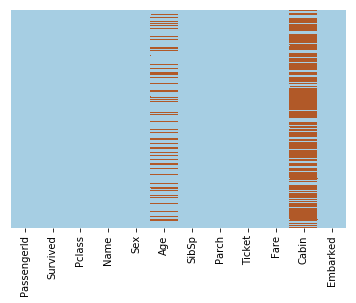

In [4]:
sns.heatmap(train.isnull(), yticklabels=False, cbar= False, cmap = 'Paired');

We have at this stage missing values in the Age and Cabin column. Let's replace the missing age by passenfer with the average age by class, and delete the Cabin Column which is including too many missing values. 

In [5]:
#function to assign the average age of the passengers of a certain class for the missing age fields.
def fill_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if  pd.isnull(Age):
        if Pclass == 1:
            return train[train['Pclass']==1]['Age'].mean()
        elif Pclass == 2:
            return train[train['Pclass']==2]['Age'].mean()
        else:
            return train[train['Pclass']==3]['Age'].mean()
    else:
        return Age

In [6]:
#apply the fill_age function
train['Age'] = train [['Age', 'Pclass']].apply(fill_age, axis=1)

In [7]:
#drop the Cabin column
train.drop('Cabin',axis=1,inplace=True)

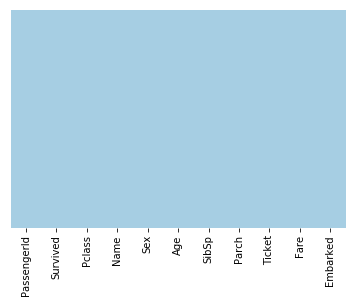

In [8]:
#check potential remaining missing value 
sns.heatmap(train.isnull(), yticklabels=False, cbar= False, cmap = 'Paired');

In [9]:
train.dropna(inplace = True)

In [10]:
trainex = train.copy()

**Dummy Variables**

In [11]:
#create dummy variables for categorical data
sex = pd.get_dummies(train['Sex'], drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)
train = pd.concat([train,sex,embark],axis=1)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,0,1


**Uniformisation of the Titles**

In [12]:
#grab the titles from the name column
train['Title']= train['Name'].str.split().str.get(1)

In [13]:
#check the unique titles as a reference for the replace method
train['Title'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Planke,', 'Don.', 'Rev.',
       'Billiard,', 'der', 'Walle,', 'Dr.', 'Pelsmaeker,', 'Mulder,', 'y',
       'Steen,', 'Carlo,', 'Mme.', 'Impe,', 'Ms.', 'Major.', 'Gordon,',
       'Messemaeker,', 'Mlle.', 'Col.', 'Capt.', 'Velde,', 'the',
       'Shawah,', 'Jonkheer.', 'Melkebeke,', 'Cruyssen,'], dtype=object)

In [14]:
#unformisation of the titles
train['Title'] = train['Title'] .replace('Mlle.', 'Miss.')
train['Title'] = train['Title'] .replace('Ms.', 'Miss.')
train['Title'] = train['Title'] .replace('Mme.', 'Mrs.')
train['Title'] = train['Title'] .replace(['Planke,', 'Don.','Billiard,', 'der', 'Walle,',
                                             'Pelsmaeker,', 'Mulder,', 'y','Steen,', 'Carlo,',
                                             'Impe,','Major.', 'Gordon,','Messemaeker,', 'Col.', 'Capt.',
                                             'Velde,', 'the','Shawah,', 'Jonkheer.', 'Melkebeke,', 'Cruyssen,'], 'Others')

In [15]:
#checking the new unique titles
train['Title'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Others', 'Rev.', 'Dr.'], dtype=object)

In [16]:
#title mapping with integers to feed the model later
title_mapping = {"Mr.": 1, "Miss.": 2, "Mrs.": 3, "Master.": 4, "Dr.": 5,  "Rev.": 6,  "Others": 7}
train['Title'] = train['Title'].map(title_mapping)

In [17]:
#drop the categorical data fields
train.drop(['Sex', 'Embarked','Name','Ticket','PassengerId'], axis =1, inplace = True)

In [18]:
#checking the dataframe at this stage
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Title
0,0,3,22.0,1,0,7.2500,1,0,1,1
1,1,1,38.0,1,0,71.2833,0,0,0,3
2,1,3,26.0,0,0,7.9250,0,0,1,2
3,1,1,35.0,1,0,53.1000,0,0,1,3
4,0,3,35.0,0,0,8.0500,1,0,1,1


## Data Exploration

Find below several plots showing the current profile of the Titanic's passengers. I will be summarazing the interesting information at the end of this sub-section.

In [19]:
trainex.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Name           889 non-null object
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [20]:
trainex.dropna(axis=0,inplace=True)

In [21]:
sns.set_style('whitegrid')

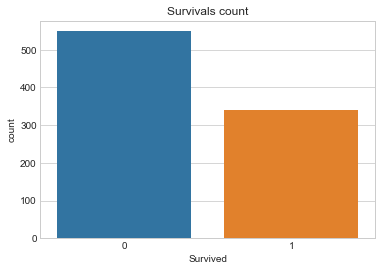

In [22]:
sns.countplot(x='Survived', data = trainex).set_title('Survivals count');

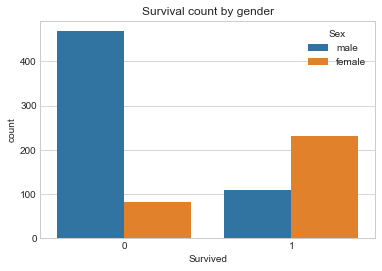

In [23]:
sns.countplot(x='Survived', data = trainex, hue='Sex').set_title('Survival count by gender');

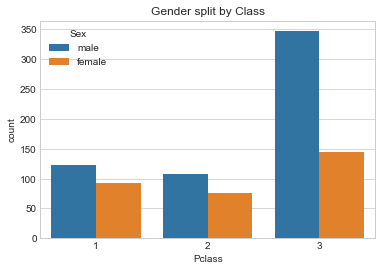

In [24]:
sns.countplot(x='Pclass', data = trainex, hue='Sex').set_title('Gender split by Class');

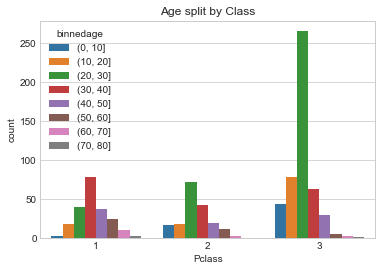

In [25]:
bins = [0,10,20,30,40,50,60,70,80]
trainex['binnedage']= pd.cut(trainex['Age'],bins)
sns.countplot(x='Pclass', data = trainex, hue='binnedage').set_title('Age split by Class');

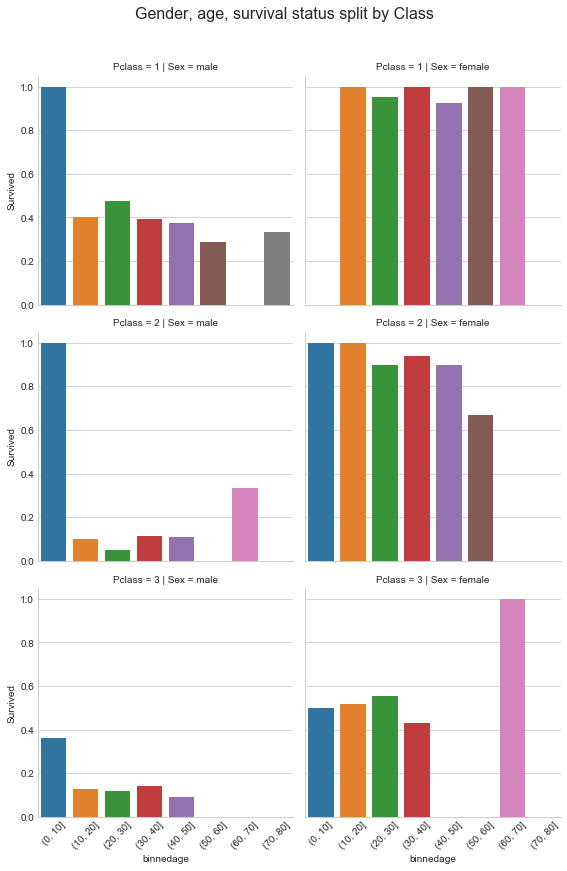

In [26]:
plt.figure(figsize = (16,8));
g = sns.factorplot(data = trainex, x = 'binnedage',col = 'Sex' , y = 'Survived', row='Pclass', kind="bar", ci=None);
g.set_xticklabels(rotation=45);
g.fig.subplots_adjust(top=0.9);
g.fig.suptitle('Gender, age, survival status split by Class', fontsize=16);

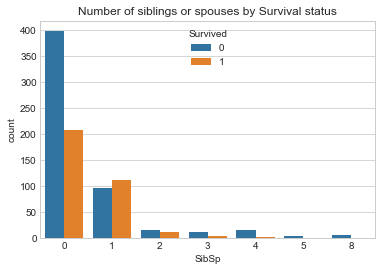

In [27]:
sns.countplot(x='SibSp', data = trainex, hue= 'Survived').set_title('Number of siblings or spouses by Survival status');

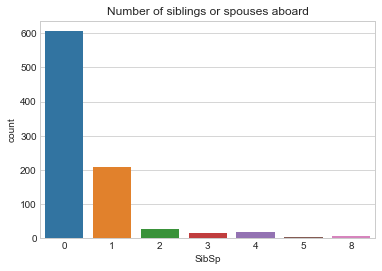

In [28]:
sns.countplot(x='SibSp', data = trainex).set_title('Number of siblings or spouses aboard');

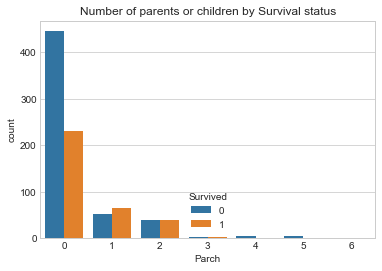

In [29]:
sns.countplot(x='Parch', data = trainex, hue= 'Survived').set_title('Number of parents or children by Survival status');

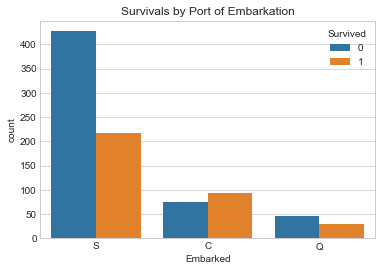

In [30]:
sns.countplot(x='Embarked', data = trainex, hue= 'Survived').set_title('Survivals by Port of Embarkation');

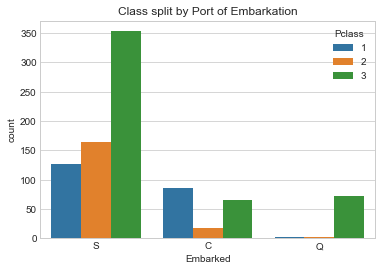

In [31]:
sns.countplot(x='Embarked', data = trainex, hue= 'Pclass').set_title('Class split by Port of Embarkation');

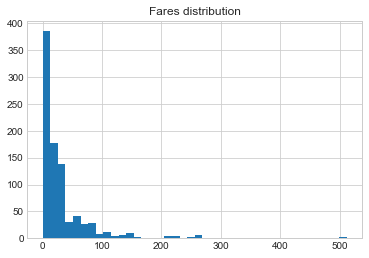

In [32]:
trainex['Fare'].hist(bins = 40).set_title('Fares distribution');

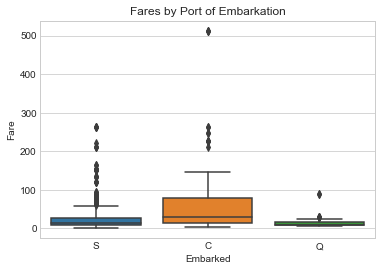

In [33]:
sns.boxplot(x='Embarked', y='Fare', data=trainex).set_title('Fares by Port of Embarkation');

**Conclusion: **

- The dataset counts 891 passengers' information in total, where 549 didn't survive and 324 did.
- We note a higher survival rate among women than men, the rate being respectively at 74% and 19%.
- Regarding the gender split, the gap is more important for the passengers from the 3rd class where there are 2 times more men than women, knowing that in the other classes the gender split is more comparable.
- The majority of the passengers are aged between 20 and 29 years old and are highly represented in the 3rd class, however, the 30 - 39 are more represented in the 1st class.
- It also seems that having siblings or spouses have an impact on the survival rate:
    - 36% for those who didn't have any
    - 53% for those who had 1
    - 46% for those who had 2
    - 25% for those who had 3 
    - 16% for those who had 4

**It's interesting to see that having 1 sibling or spouse was the best profile for survival, the rate is decreasing with the number of spouse or sibling increasing.**

- It also seems that having a parent or a child was also impacting the survival rate:
    - 34% for those who didn't have any
    - 56% for those who had 1
    - 50% for those who had 2
   
** In this case as well, 1 was the perfect number. But comparing the two, it seems that having a parent or a child had a better influence on the survival rate than having a sibling or a spouse.**

We also learn from this analysis that most passengers who didn't survive embarked in Southampton (S) and those people mainly bought a 3rd class ticket. The last boxplot also shows that the average ticket cost is lower for the passengers who started their trip from Southampton and higher for those who started from Cherbourg (C). We can then conclude more diversity (mixed profiles) coming from Cherbourg than Southampton.

In the second part, we are going to predict the survivors from the test file, knowing that some aspect could influence their chance to survive.

# Part 2: Predicitions

## Model preparation

In [34]:
#starting from this dataframe
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Title
0,0,3,22.0,1,0,7.2500,1,0,1,1
1,1,1,38.0,1,0,71.2833,0,0,0,3
2,1,3,26.0,0,0,7.9250,0,0,1,2
3,1,1,35.0,1,0,53.1000,0,0,1,3
4,0,3,35.0,0,0,8.0500,1,0,1,1


In [35]:
#select our training data and the target value
X = train.drop('Survived',axis=1)
y = train['Survived']

In [36]:
#import train_test_split
from sklearn.model_selection import train_test_split

In [37]:
#split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [38]:
#import the logistic regression method for classification 
from sklearn.linear_model import LogisticRegression

In [39]:
#create a logistic regression object
logmodel = LogisticRegression()

In [40]:
#apply the method on a training data
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [41]:
#get our predictions
predictions = logmodel.predict(X_test)

In [42]:
from sklearn.metrics import confusion_matrix

In [43]:
print(confusion_matrix(y_test,predictions))

[[151  12]
 [ 34  70]]


In [44]:
#import classification report for model evaluation
from sklearn.metrics import classification_report

In [45]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.82      0.93      0.87       163
          1       0.85      0.67      0.75       104

avg / total       0.83      0.83      0.82       267



From the passengers labeled as survived by our model 85% actually survived. 
From the passengers who truly survived, the model managed to label 67% of them.

## Apply the model to the test file

**Clean the dataset**

In [46]:
#same cleaning steps as for the training dataset
test = pd.read_csv('titanic_test.csv')

In [47]:
test.drop('Cabin',axis=1,inplace=True)

In [48]:
test.isnull().sum()

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            1
Embarked        0
dtype: int64

In [49]:
test['Age'] = test [['Age', 'Pclass']].apply(fill_age, axis=1)

In [50]:
test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Embarked       0
dtype: int64

In [51]:
test[pd.isnull(test['Fare'])]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S


In [52]:
#replace the null fare field with the mean cost for this specific class (3)
train[train['Pclass']==3]['Fare'].mean()

13.675550101832993

In [53]:
test['Fare']=test['Fare'].fillna(train[train['Pclass']==3]['Fare'].mean())

In [54]:
#no more null values
test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [55]:
sextest = pd.get_dummies(test['Sex'], drop_first=True)
embarktest = pd.get_dummies(test['Embarked'],drop_first=True)
test = pd.concat([test,sextest,embarktest],axis=1)

In [56]:
test['Title'] = test['Name'].str.split(', ').str.get(1).str.split(' ').str.get(0)

In [57]:
test['Title'] = test['Title'] .replace('Mlle.', 'Miss.')
test['Title'] = test['Title'] .replace('Ms.', 'Miss.')
test['Title'] = test['Title'] .replace('Mme.', 'Mrs.')
test['Title'] = test['Title'] .replace(['Planke,', 'Don.','Dona.','Billiard,', 'der', 'Walle,',
                                             'Pelsmaeker,', 'Mulder,', 'y','Steen,', 'Carlo,',
                                             'Impe,','Major.', 'Gordon,','Messemaeker,', 'Col.', 'Capt.',
                                             'Velde,', 'the','Shawah,', 'Jonkheer.', 'Melkebeke,', 'Cruyssen,'], 'Others')


In [58]:
title_mapping = {"Mr.": 1, "Miss.": 2, "Mrs.": 3, "Master.": 4, "Dr.": 5,  "Rev.": 6,  "Others": 7}
test['Title'] = test['Title'].map(title_mapping)

In [59]:
final = test.copy()

In [60]:
#drop unnecessary fields
test.drop(['Sex', 'Embarked','Name','Ticket'], axis =1, inplace = True)

In [61]:
test.drop('PassengerId', axis =1, inplace = True)

**Apply the model**

In [62]:
predictr = logmodel.predict(test)

In [63]:
test.head()

,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Title
0,3,34.5,0,0,7.8292,1,1,0,1
1,3,47.0,1,0,7.0000,0,0,1,3
2,2,62.0,0,0,9.6875,1,1,0,1
3,3,27.0,0,0,8.6625,1,0,1,1
4,3,22.0,1,1,12.2875,0,0,1,3


In [64]:
#create new column for the survivals predictions
final['Survived_Pred'] = predictr

In [65]:
#print final table, passengerid and survival status matching
final = final[['PassengerId','Survived_Pred']].head()
final

,PassengerId,Survived_Pred
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
